<a href="https://colab.research.google.com/github/emorysmithis/pupil-cluster/blob/main/BCI_dilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch

# Notes from class

could also be interesting to keep track of blinks because of correlations:
- dopamine
- working memory
-


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import glob
base_directory = '/content/drive/MyDrive/Fall 2025/BCI/dilation-dataset'
all_trial_dataframes = []
for filename in glob.glob(f'{base_directory}/WM study/Eye data/*/*.gazedata'):
  raw_dataframe = pd.read_csv(
    filename,
    sep='\t',
    low_memory=False)
  # split by trial id
  for trial_id in raw_dataframe['TrialId'].unique():
    trial_dataframe = raw_dataframe[raw_dataframe['TrialId'] == trial_id]


    # drop metadata
    trial_dataframe = trial_dataframe.drop(columns=[
      'ID', 'RTTime', 'TimestampSec', 'TimestampMicrosec'])

    # drop specific movements since they will probably not be generalizable
    trial_dataframe = trial_dataframe.drop(columns=[
        'XGazePosLeftEye', 'YGazePosLeftEye', 'XCameraPosLeftEye', 'YCameraPosLeftEye',
        'XGazePosRightEye', 'YGazePosRightEye', 'XCameraPosRightEye', 'YCameraPosRightEye',
        'DistanceLeftEye', 'DistanceRightEye'
    ])

    all_trial_dataframes.append(trial_dataframe)

In [38]:
print(f"Num trials before removing any: {len(all_trial_dataframes)}")
 # NOTE: fixed this. You cannot pop inside the loop because that messes with the indexing.

filtered_all_trial_dataframes = []
for index, trial in enumerate(all_trial_dataframes):
  # 1. remove empty trials
  if trial.empty:
    continue
  # 2. remove trials where left pupil diameter is 0 more than threshold
  zero_threshold = len(trial) / 2 # half the time, 50%
  if sum(a > 0 for a in trial['DiameterPupilLeftEye']) < zero_threshold:
    continue

  # 3. remove trials where right pupil diameter is 0 more than threshold
  if sum(a > 0 for a in trial['DiameterPupilRightEye']) < zero_threshold:
    continue

  # 4. remove trials where validity of right eye is not valid more than threshold
  valid_threshold = len(trial) / 2
  if sum(a == 0 for a in trial['ValidityRightEye']) < zero_threshold:
    continue

  # 5. remove trials where validity of left eye is not valid more than threshold
  if sum(a == 0 for a in trial['ValidityLeftEye']) < zero_threshold:
    continue

  trial['ElapsedTime'] = trial['TETTime'] - trial['TETTime'].iloc[0]
  filtered_all_trial_dataframes.append(trial)


print(f"Num trials remaining after removing empty and half-empty trials: {len(filtered_all_trial_dataframes)}")
all_trial_dataframes = filtered_all_trial_dataframes

Num trials before removing any: 12275
Num trials remaining after removing empty and half-empty trials: 10765


In [39]:
# interpolate DiameterPupilLeftEye and DiameterPupilRightEye using MNE
MAX=6
MIN=1
num_linear_fallback = 0
for index, trial in enumerate(filtered_all_trial_dataframes):
  # also cutting bad data (e.g. eye partially closed)
  trial.loc[:, "DiameterPupilRightEye"] = trial["DiameterPupilRightEye"].apply(
    lambda x: np.nan if x < MIN or x > MAX else x)
  trial.loc[:, "DiameterPupilLeftEye"] = trial["DiameterPupilLeftEye"].apply(
    lambda x: np.nan if x < MIN or x > MAX else x)


  # TODO: need to do something about false values (blink making the percieved pupil diameter look tiny then interpolation making it blow up)
  # dumb way would be to also make values around blinks NanN too
  try:
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilLeftEye'] = trial['DiameterPupilLeftEye'].interpolate(method='linear')
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilRightEye'] = trial['DiameterPupilRightEye'].interpolate(method='linear')

    #filtered_all_trial_dataframes[index] = trial.interpolate(method='pchip')
  except:
    num_linear_fallback+=1
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilLeftEye'] = trial['DiameterPupilLeftEye'].interpolate()
    filtered_all_trial_dataframes[index].loc[:, 'DiameterPupilRightEye'] = trial['DiameterPupilRightEye'].interpolate()

print(f"failed interpolation and fell back to linear {num_linear_fallback} times")

all_trial_dataframes[7]
num_nans_right = all_trial_dataframes[7]['DiameterPupilRightEye'].isna().sum()
print("NaNs in DiameterPupilRightEye:", num_nans_right)

failed interpolation and fell back to linear 0 times
NaNs in DiameterPupilRightEye: 0


In [40]:
# all_trial_dataframes[41][all_trial_dataframes[41]["DiameterPupilLeftEye"] != ]
value_nan = all_trial_dataframes[41].iloc[0]['DiameterPupilLeftEye']
all_trial_dataframes[41][all_trial_dataframes[41]["DiameterPupilLeftEye"].notna()]

,Subject,Session,TETTime,DiameterPupilLeftEye,ValidityLeftEye,DiameterPupilRightEye,ValidityRightEye,TrialId,NumCorrect,CurrentObject,ElapsedTime
31028,1062,1,818482.484,3.046830,0,3.351223,0,45,3,NaN,0.000
31029,1062,1,818490.810,3.069574,4,3.216224,0,45,3,NaN,8.326
31030,1062,1,818499.147,3.092319,4,3.269796,0,45,3,PreTrialBlank,16.663
31031,1062,1,818507.474,3.115063,0,3.232251,0,45,3,PreTrialBlank,24.990
31032,1062,1,818515.809,3.108579,0,3.263538,0,45,3,PreTrialBlank,33.325
...,...,...,...,...,...,...,...,...,...,...,...
31727,1062,1,824306.584,3.588148,0,3.621057,0,45,3,Mask,5824.100
31728,1062,1,824314.912,3.627297,0,3.636315,0,45,3,Mask,5832.428
31729,1062,1,824323.247,3.493481,0,3.629940,0,45,3,Mask,5840.763
31730,1062,1,824331.580,3.476093,0,3.663558,0,45,3,Mask,5849.096


In [41]:
all_trial_dataframes[41]

,Subject,Session,TETTime,DiameterPupilLeftEye,ValidityLeftEye,DiameterPupilRightEye,ValidityRightEye,TrialId,NumCorrect,CurrentObject,ElapsedTime
31028,1062,1,818482.484,3.046830,0,3.351223,0,45,3,NaN,0.000
31029,1062,1,818490.810,3.069574,4,3.216224,0,45,3,NaN,8.326
31030,1062,1,818499.147,3.092319,4,3.269796,0,45,3,PreTrialBlank,16.663
31031,1062,1,818507.474,3.115063,0,3.232251,0,45,3,PreTrialBlank,24.990
31032,1062,1,818515.809,3.108579,0,3.263538,0,45,3,PreTrialBlank,33.325
...,...,...,...,...,...,...,...,...,...,...,...
31727,1062,1,824306.584,3.588148,0,3.621057,0,45,3,Mask,5824.100
31728,1062,1,824314.912,3.627297,0,3.636315,0,45,3,Mask,5832.428
31729,1062,1,824323.247,3.493481,0,3.629940,0,45,3,Mask,5840.763
31730,1062,1,824331.580,3.476093,0,3.663558,0,45,3,Mask,5849.096


In [8]:
filtered_all_trial_dataframes[0]

,Subject,Session,TETTime,DiameterPupilLeftEye,ValidityLeftEye,DiameterPupilRightEye,ValidityRightEye,TrialId,NumCorrect,CurrentObject,ElapsedTime
705,1062,1,149668.198,NaN,4,NaN,4,2,1,NaN,0.000
706,1062,1,149676.515,NaN,4,NaN,4,2,1,NaN,8.317
707,1062,1,149684.857,NaN,4,NaN,4,2,1,PreTrialBlank,16.659
708,1062,1,149693.184,4.202194,0,3.782363,0,2,1,PreTrialBlank,24.986
709,1062,1,149701.511,4.128318,0,3.799452,0,2,1,PreTrialBlank,33.313
...,...,...,...,...,...,...,...,...,...,...,...
1405,1062,1,155500.622,3.763689,0,3.363882,0,2,1,Mask,5832.424
1406,1062,1,155508.952,3.694301,0,3.704039,0,2,1,Mask,5840.754
1407,1062,1,155517.283,3.891111,0,3.660562,0,2,1,Mask,5849.085
1408,1062,1,155525.616,3.722566,0,3.609494,0,2,1,Mask,5857.418


In [9]:
from IPython.display import display, HTML
mask_dataframes = []
for index, trial_df in enumerate(filtered_all_trial_dataframes):
  fixation_df = trial_df[trial_df["CurrentObject"] == "Fixation"]

  baseline_left_pupil = fixation_df[fixation_df["DiameterPupilLeftEye"].notna()]["DiameterPupilLeftEye"].mean() # get mean of pupil diameter, but don't include diameter == -1
  baseline_right_pupil = fixation_df[fixation_df["DiameterPupilRightEye"].notna()]["DiameterPupilRightEye"].mean() # get mean of pupil diameter, but don't include diameter == -1
  if pd.isna(baseline_left_pupil) or pd.isna(baseline_right_pupil):
    print(f"Skipping trial {index} due to NaN baseline")
    continue

  trial_df.loc[:, "DilationPupilRightEye"] = np.where(
    (trial_df["CurrentObject"] == "Mask") & (trial_df["DiameterPupilRightEye"].notna()),
    trial_df["DiameterPupilRightEye"] - baseline_right_pupil,
    np.nan)

  trial_df.loc[:, "DilationPupilLeftEye"] = np.where(
    (trial_df["CurrentObject"] == "Mask") & (trial_df["DiameterPupilLeftEye"].notna()),
    trial_df["DiameterPupilLeftEye"] - baseline_left_pupil,
    np.nan)

  mask_dataframes.append(trial_df.loc[trial_df["CurrentObject"] == "Mask"].copy())

# mask_dataframes = [df.loc[df["CurrentObject"] == "Mask"].copy() for df in filtered_all_trial_dataframes] # remove all parts of trial except "delay period" which is the period we care about

Skipping trial 147 due to NaN baseline
Skipping trial 159 due to NaN baseline
Skipping trial 161 due to NaN baseline
Skipping trial 652 due to NaN baseline
Skipping trial 2654 due to NaN baseline
Skipping trial 3304 due to NaN baseline
Skipping trial 3572 due to NaN baseline
Skipping trial 3592 due to NaN baseline
Skipping trial 3598 due to NaN baseline
Skipping trial 3610 due to NaN baseline
Skipping trial 3616 due to NaN baseline
Skipping trial 3725 due to NaN baseline
Skipping trial 3748 due to NaN baseline
Skipping trial 3759 due to NaN baseline
Skipping trial 3810 due to NaN baseline
Skipping trial 3821 due to NaN baseline
Skipping trial 4018 due to NaN baseline
Skipping trial 4019 due to NaN baseline
Skipping trial 4037 due to NaN baseline
Skipping trial 4054 due to NaN baseline
Skipping trial 4065 due to NaN baseline
Skipping trial 4069 due to NaN baseline
Skipping trial 4152 due to NaN baseline
Skipping trial 4506 due to NaN baseline
Skipping trial 4528 due to NaN baseline
Skip

In [10]:
display(HTML(mask_dataframes[0][['Subject', 'TrialId', 'DiameterPupilLeftEye', 'DiameterPupilRightEye', 'DilationPupilLeftEye', 'DilationPupilRightEye', 'CurrentObject']][:20].to_html()))

,Subject,TrialId,DiameterPupilLeftEye,DiameterPupilRightEye,DilationPupilLeftEye,DilationPupilRightEye,CurrentObject
941,1062,2,3.425147,3.060601,-0.244415,-0.468288,Mask
942,1062,2,3.769574,3.090249,0.100012,-0.438640,Mask
943,1062,2,3.668901,3.045698,-0.000661,-0.483191,Mask
944,1062,2,3.537927,3.326987,-0.131635,-0.201902,Mask
945,1062,2,3.607704,2.943096,-0.061858,-0.585793,Mask
946,1062,2,3.703842,2.869495,0.034280,-0.659394,Mask
947,1062,2,3.718366,3.097484,0.048804,-0.431405,Mask
948,1062,2,3.689266,3.273841,0.019704,-0.255048,Mask
949,1062,2,3.588250,2.933803,-0.081312,-0.595086,Mask
950,1062,2,3.599510,3.222814,-0.070052,-0.306075,Mask


In [31]:
import random
import matplotlib.pyplot as plt

# Select three random trial dataframes
#random_trials = random.sample(filtered_all_trial_dataframes, 3)
numbers = random.sample(range(0, len(filtered_all_trial_dataframes)), 10)  # picks 3 unique numbers from 0 to x inclusive
print(numbers)

[8256, 6676, 5619, 8432, 3430, 2622, 10698, 1204, 6136, 4785]


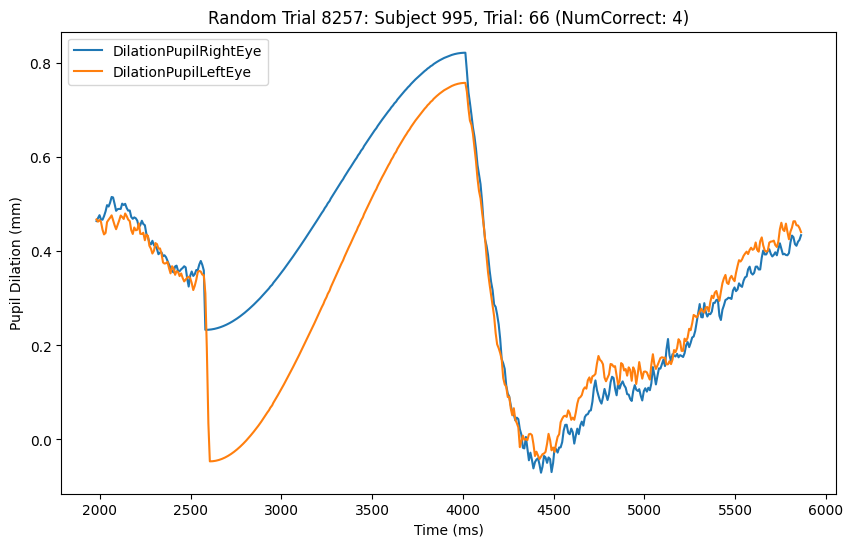

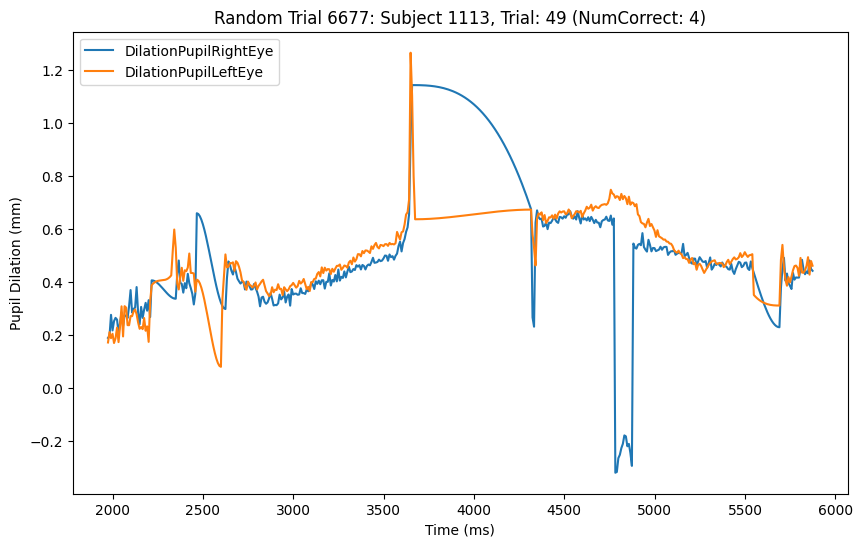

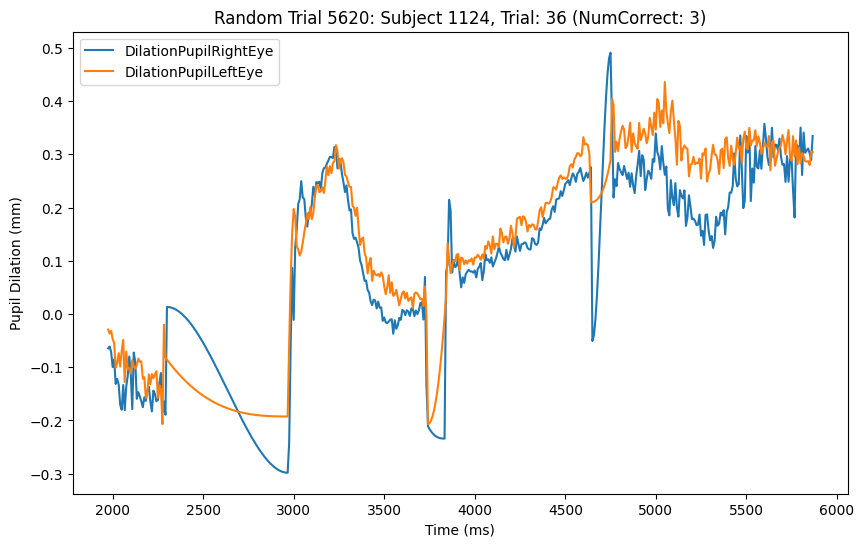

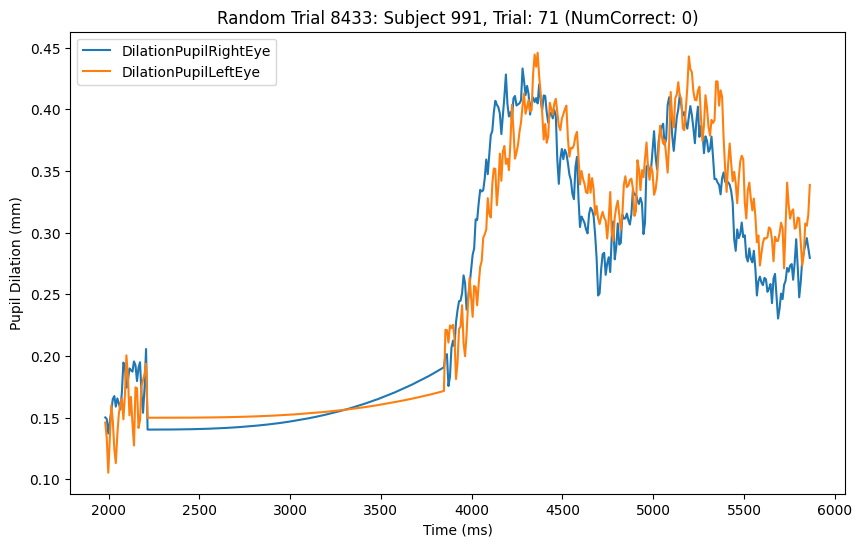

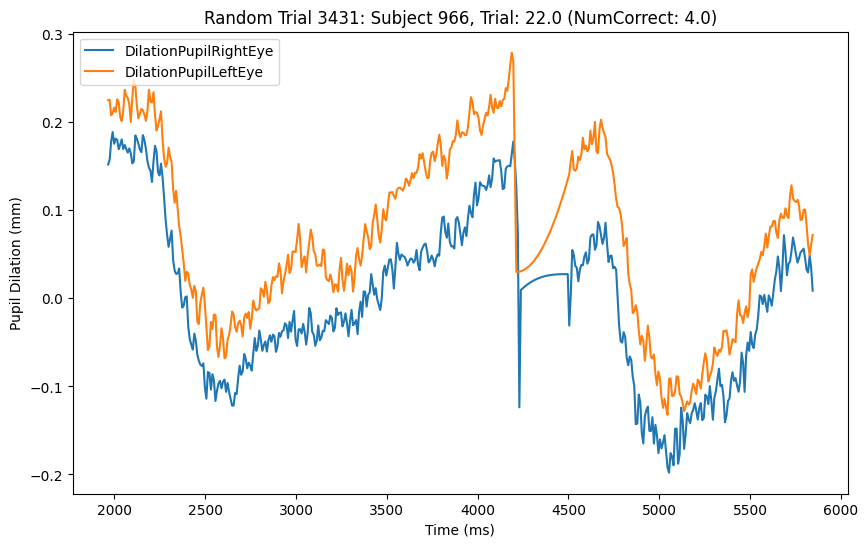

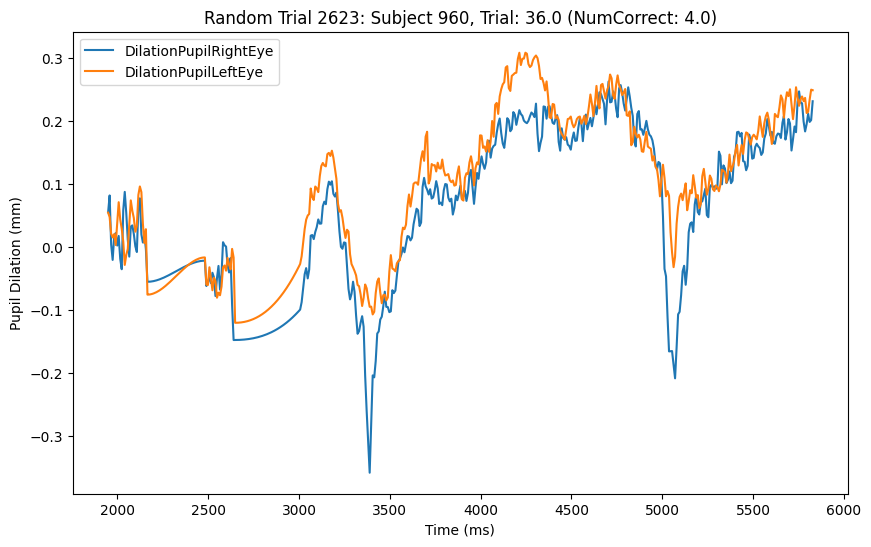

IndexError: list index out of range

In [32]:
# Plot each trial
for i in numbers:
    trial_df = mask_dataframes[i]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for column in trial_df.columns:
        if column == 'DilationPupilLeftEye' or column == 'DilationPupilRightEye': # Exclude the label from plotting
          ax1.plot(trial_df['ElapsedTime'], trial_df[column], label=column)

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Pupil Dilation (mm)')
    plt.title(f'Random Trial {i+1}: Subject {trial_df['Subject'].iloc[0]}, Trial: {trial_df["TrialId"].iloc[0]} (NumCorrect: {trial_df["NumCorrect"].iloc[0]})')
    ax1.legend(loc='upper left')
    plt.show()

In [13]:
# Low Pass Filter
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Filter
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# parameters
fs = 120  # sampling rate in Hz (change to your eye tracker rate)
cutoff = 5  # cutoff frequency in Hz

for i, trial_df in enumerate(mask_dataframes):
  mask_dataframes[i].loc[:, 'SmoothedDilationPupilLeftEye'] = lowpass_filter(
    mask_dataframes[i]['DilationPupilLeftEye'], cutoff, fs)
  mask_dataframes[i].loc[:, 'SmoothedDilationPupilRightEye'] = lowpass_filter(
    mask_dataframes[i]['DilationPupilRightEye'], cutoff, fs)

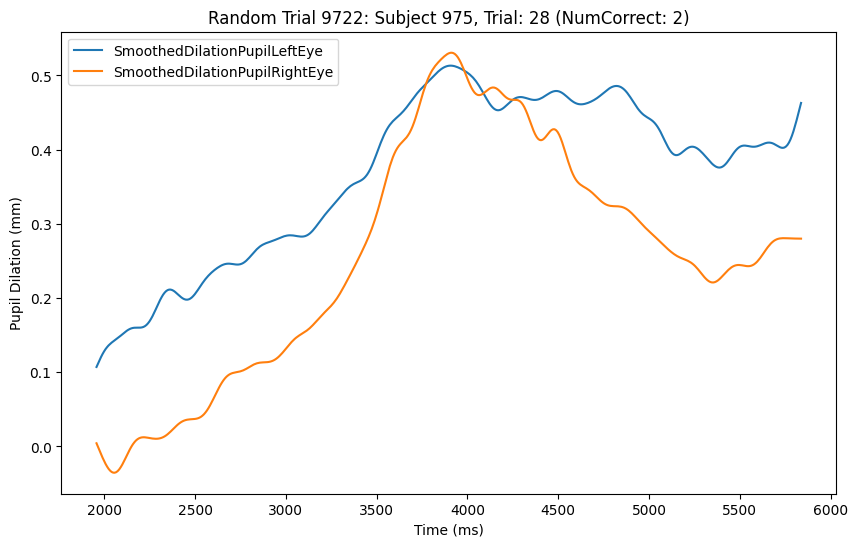

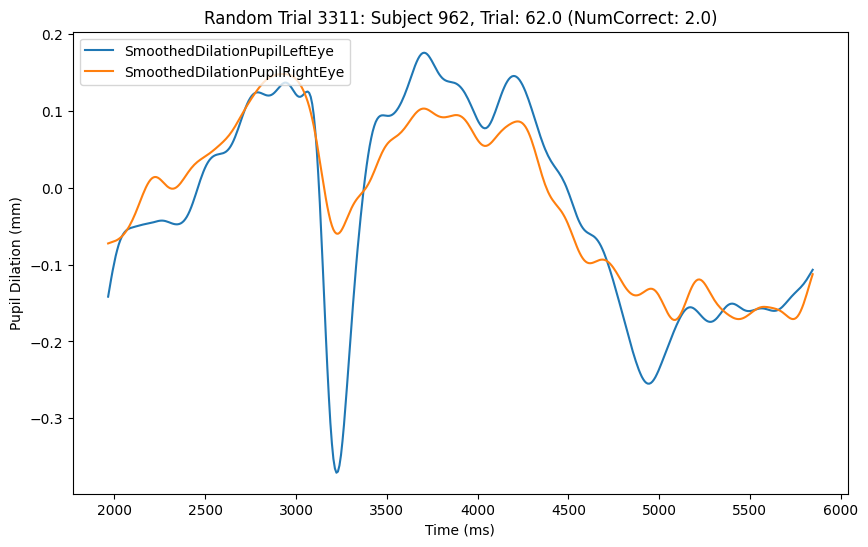

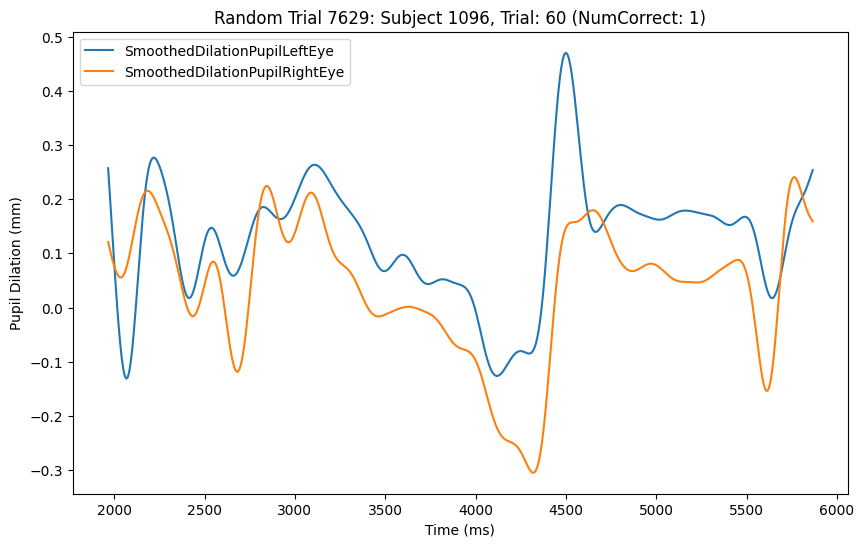

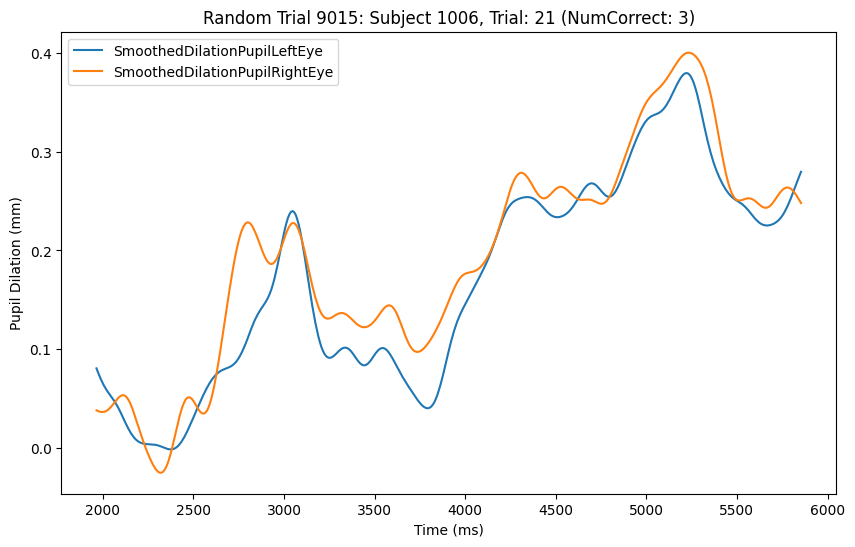

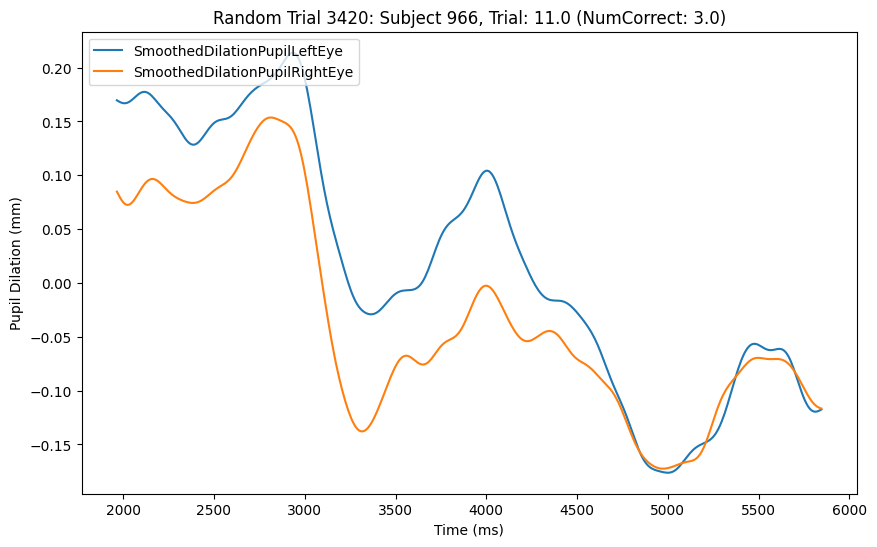

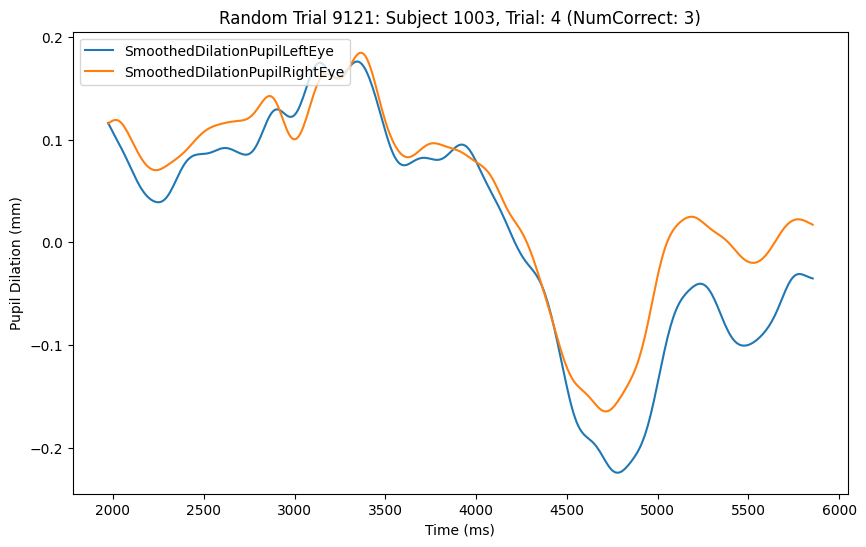

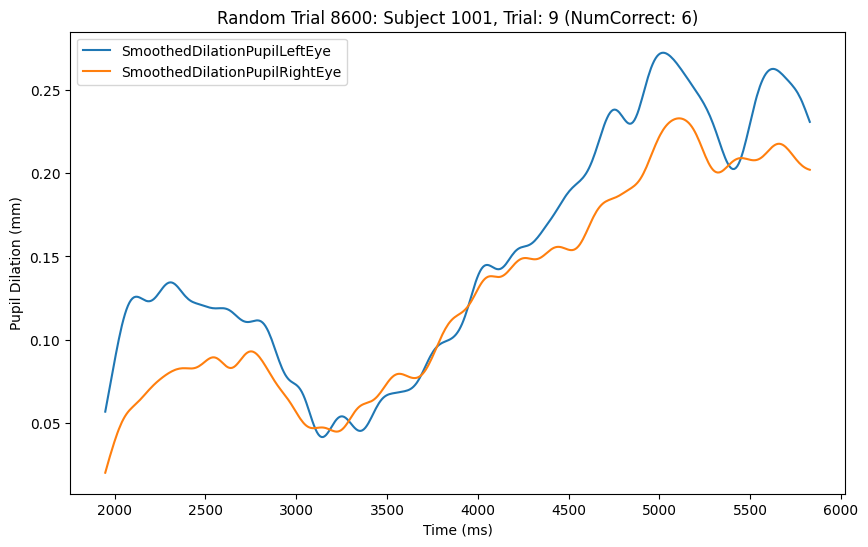

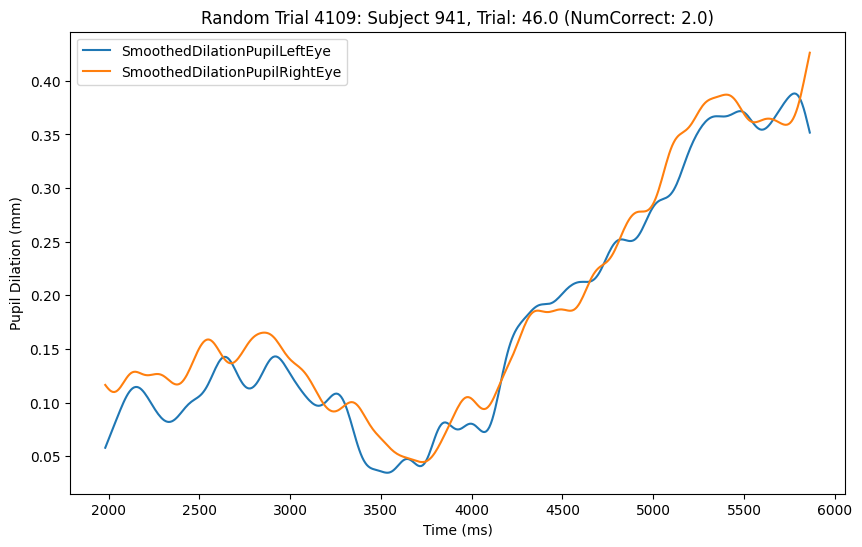

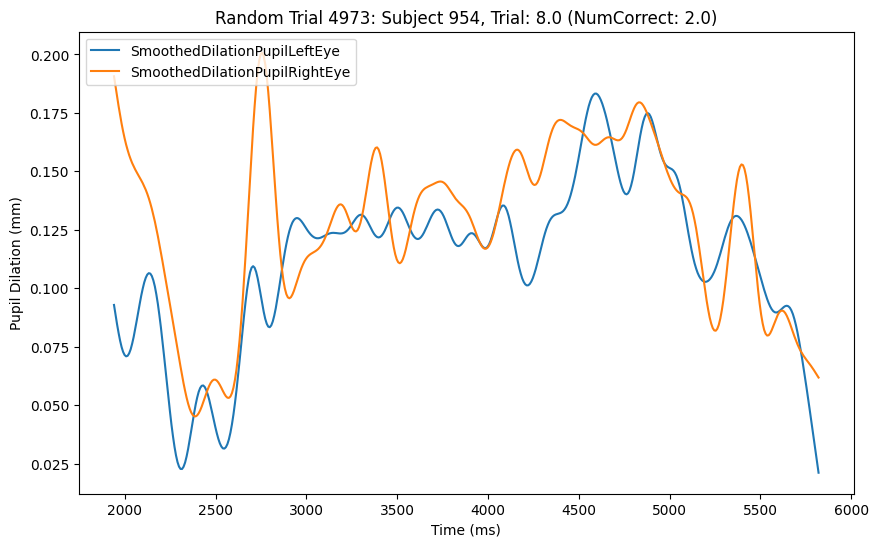

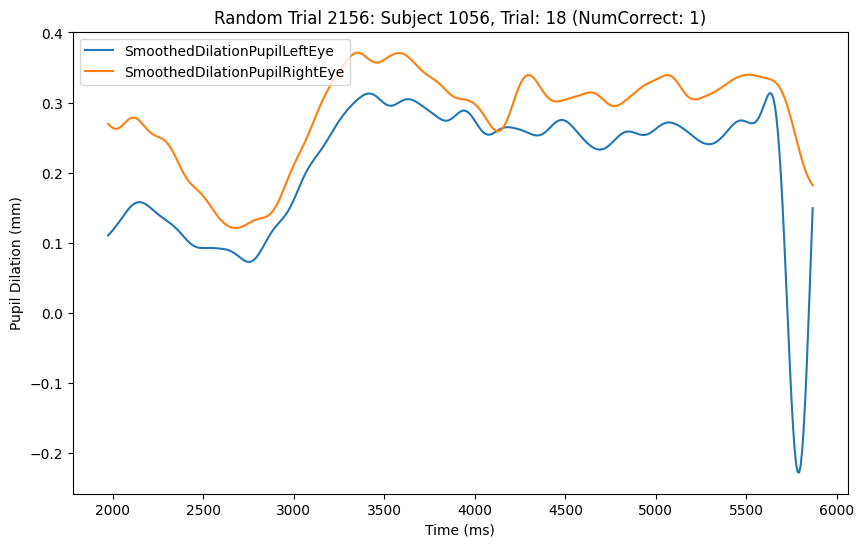

In [14]:
# Plot each trial
for i in numbers:
    trial_df = mask_dataframes[i]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for column in trial_df.columns:
        if column == 'SmoothedDilationPupilLeftEye' or column == 'SmoothedDilationPupilRightEye': # Exclude the label from plotting
          ax1.plot(trial_df['ElapsedTime'], trial_df[column], label=column)

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Pupil Dilation (mm)')
    plt.title(f'Random Trial {i+1}: Subject {trial_df['Subject'].iloc[0]}, Trial: {trial_df["TrialId"].iloc[0]} (NumCorrect: {trial_df["NumCorrect"].iloc[0]})')
    ax1.legend(loc='upper left')
    plt.show()

In [15]:
mask_dataframes[0]

,Subject,Session,TETTime,DiameterPupilLeftEye,ValidityLeftEye,DiameterPupilRightEye,ValidityRightEye,TrialId,NumCorrect,CurrentObject,ElapsedTime,DilationPupilRightEye,DilationPupilLeftEye,SmoothedDilationPupilLeftEye,SmoothedDilationPupilRightEye
941,1062,1,151634.549,3.425147,0,3.060601,0,2,1,Mask,1966.351,-0.468288,-0.244415,-0.246752,-0.460946
942,1062,1,151642.884,3.769574,0,3.090249,0,2,1,Mask,1974.686,-0.438640,0.100012,-0.209562,-0.463189
943,1062,1,151651.214,3.668901,0,3.045698,0,2,1,Mask,1983.016,-0.483191,-0.000661,-0.173414,-0.464267
944,1062,1,151659.548,3.537927,0,3.326987,0,2,1,Mask,1991.350,-0.201902,-0.131635,-0.139333,-0.463100
945,1062,1,151667.879,3.607704,0,2.943096,0,2,1,Mask,1999.681,-0.585793,-0.061858,-0.108200,-0.458772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,1062,1,155500.622,3.763689,0,3.363882,0,2,1,Mask,5832.424,-0.165007,0.094127,0.154681,-0.192181
1406,1062,1,155508.952,3.694301,0,3.704039,0,2,1,Mask,5840.754,0.175150,0.024739,0.162192,-0.222123
1407,1062,1,155517.283,3.891111,0,3.660562,0,2,1,Mask,5849.085,0.131673,0.221549,0.170459,-0.254440
1408,1062,1,155525.616,3.722566,0,3.609494,0,2,1,Mask,5857.418,0.080605,0.053004,0.179172,-0.288150


In [33]:
# make new column of max dilation over timeframe
from collections import defaultdict
from statistics import mean
TIME_FRAME = 500
CUTOFF = 1
max_dilation_dict = defaultdict(list)
for trial in mask_dataframes:
  # find the max dilation and add it to max_dilation_dict
  max_dilation = 0
  for i in range(0, len(trial), TIME_FRAME):
    frame_dilation = max(
        mean(trial['SmoothedDilationPupilLeftEye'][i:i+TIME_FRAME]),
        mean(trial['SmoothedDilationPupilRightEye'][i:i+TIME_FRAME]))
    max_dilation = max(max_dilation, frame_dilation)
  if max_dilation > CUTOFF:
    print(f"Skipping max dilation: {max_dilation}")
    continue
  max_dilation_dict[trial['NumCorrect'].iloc[0]].append(max_dilation)

Skipping max dilation: 3.613431845897363
Skipping max dilation: 1.7986031506422901
Skipping max dilation: 4.465619087689496
Skipping max dilation: 1.6355129704548035
Skipping max dilation: 1.271743758460517
Skipping max dilation: 1.2241810649245326
Skipping max dilation: 1.2510438659730019
Skipping max dilation: 9.464893930990373
Skipping max dilation: 1.0457603065188237
Skipping max dilation: 3.4921742826449145
Skipping max dilation: 1.9901130014996136
Skipping max dilation: 8.286895426866884
Skipping max dilation: 1.987228784617342
Skipping max dilation: 2.970938460955044
Skipping max dilation: 1.1655181336550047
Skipping max dilation: 1.509658852360306
Skipping max dilation: 13.66302408241865
Skipping max dilation: 1.091789558334236
Skipping max dilation: 20.080132187600388
Skipping max dilation: 10.073811495036527
Skipping max dilation: 1.292039533032633
Skipping max dilation: 5.025622864396165
Skipping max dilation: 11647.128114105584
Skipping max dilation: 2.8131607936403675
Skip

defaultdict(list,
            {np.int64(1): [0.5021489117387924,
              0.940054671150914,
              1.0845893435694436,
              0.4539209945246172,
              0.31217843497965236,
              0.5255280555279966,
              0.22403012722174998,
              0.47524592556907175,
              0.24930050423362818,
              0.4026918628016558,
              0.2971258045859281,
              0.09443565037008755,
              0.5306752280087385,
              0.7496513014936145,
              0.4360704032767447,
              0.3053967805471331,
              0.41347408711339084,
              0.07900192319568762,
              0.4775857693445612,
              0.4318861678552551,
              0.674811513116549,
              66.7203469806485,
              0.4790720957157631,
              0.28213504970198633,
              1.589290252060229,
              0.598028892068855,
              0.40408001197952165,
              0.9139104278800294,
              

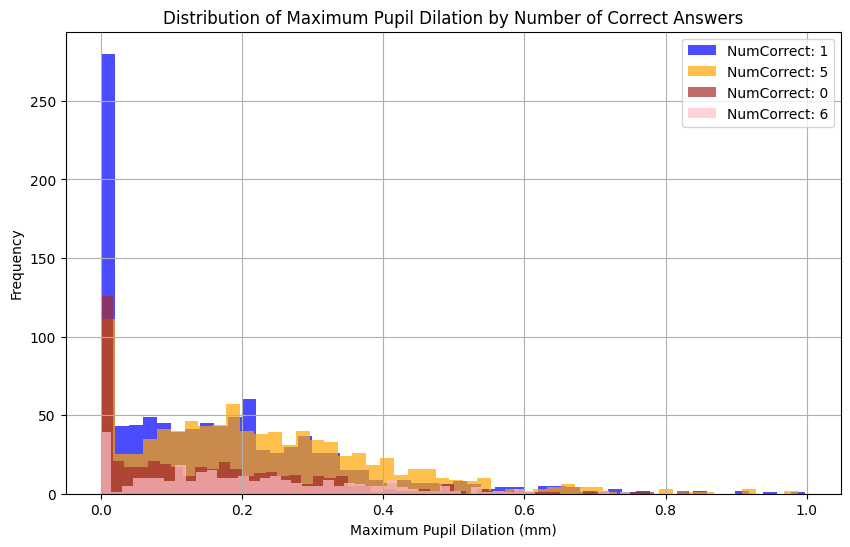

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define a list of colors for each category
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i, (key, values) in enumerate(max_dilation_dict.items()):
    # Ensure we don't run out of colors if there are more categories than defined colors
    if key not in [0, 1, 5, 6]:
      continue
    color = colors[i % len(colors)]
    plt.hist(values, bins=50, alpha=0.7, label=f'NumCorrect: {key}', color=color)

plt.xlabel('Maximum Pupil Dilation (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum Pupil Dilation by Number of Correct Answers')
plt.legend()
plt.grid(True)
plt.show()